In [289]:

import os
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from ast import literal_eval


# loop over and load in behavioural data from useable mirs
def find_organised_path(mir,dat_path):
    dat_path_2 = None
    recording = None
    print(mir)
    for animal_implant in os.listdir(dat_path):
        current_m_i = '_'.join([animal_implant.split('_')[0],animal_implant.split('_')[-1][-1]])
        mi = '_'.join(mir.split('_')[0:-1])
        if current_m_i == mi:
            dat_path_2 = os.path.join(dat_path,animal_implant)
            break
    print(dat_path_2)
    for ind,item in enumerate([record.split('ing')[-1].split('_')[0] for record in os.listdir(dat_path_2)]):
        if item == mir.split('_')[-1]:
            recording = os.listdir(dat_path_2)[ind]
    full_org_dat_path = os.path.join(dat_path_2,recording)
    print(full_org_dat_path)
    return full_org_dat_path

def load_behav_sync(full_org_dat_path):
    # List all items in the directory
    items = os.listdir(os.path.join(full_org_dat_path, 'behav_sync/'))
    # Find the string that contains 'task'
    task_item = next((item for item in items if 'task' in item), None)
    # Add it to the path
    if task_item:
        task_path = os.path.join(full_org_dat_path, 'behav_sync/', task_item)
        print(task_path)
    else:
        print("No task dir found in behav_sync")
        
    behav_sync_csv = next((item for item in os.listdir(task_path) if 'Behav' in item), None)
    behav_sync_csv_path = os.path.join(task_path,behav_sync_csv)

    return pd.read_csv(behav_sync_csv_path)

def find_awake_ppseq_base_path(mir,awake_ppseq_path):
    awake_ppseq_mirs = np.array(['_'.join(item.split('_')[0:3]) for item in os.listdir(awake_ppseq_path)])
    awake_file_mir = None
    for ind,item in enumerate(awake_ppseq_mirs):
        if item in mir:
            awake_file_mir = os.listdir(awake_ppseq_path)[ind]
    if awake_file_mir == None:
        raise Exception("No awake file found for mir")
    else:
        return(os.path.join(awake_ppseq_path,awake_file_mir))
    
def get_sequence_regions(mir,awake_ppseq_base_path,sequence_order):
    standard_space_path = awake_ppseq_base_path + r'//analysis_output/reordered_recolored/fixed_standard_space//'
    overlap_positions_standard_space = np.load(standard_space_path + 'overlap_positions_standard_space.npy',allow_pickle=True)

    mir_row = None
    for ind, row in sequence_order.iterrows():
        if row.mir in mir:
            mir_row = row
    seq_order = literal_eval(mir_row.seq_order)
    continuous_regions = []
    fig, ax = plt.subplots(1,1,figsize=(8, 2))
    for i,seq in enumerate(seq_order):
        ax.plot(overlap_positions_standard_space[seq],np.ones(len(overlap_positions_standard_space[seq]))*i,'o')
        continuous_regions += [find_largest_continuous_region(overlap_positions_standard_space[seq])]

    # create new df 
    continuous_regions_df = pd.DataFrame(continuous_regions,columns=['start','end'])
    continuous_regions_df['sequence'] = seq_order
    return continuous_regions_df


def find_largest_continuous_region(positions, max_gap=5, circular_max=100):
    # Sort positions for easier processing
    positions = sorted(positions)
    
    # Identify continuous regions
    regions = []
    current_region = [positions[0]]
    
    for i in range(1, len(positions)):
        if positions[i] - positions[i - 1] < max_gap:
            current_region.append(positions[i])
        else:
            regions.append(current_region)
            current_region = [positions[i]]
    
    regions.append(current_region)  # Append the last region
    
    # Handle circular case (if the first and last regions can be merged)
    if regions and len(regions) > 1:
        first_region = regions[0]
        last_region = regions[-1]
        
        if (circular_max - last_region[-1] + first_region[0]) < max_gap:
            merged_region = last_region + first_region
            regions = regions[1:-1]  # Remove first and last
            regions.append(merged_region)
    
    # Find the largest region
    largest_region = max(regions, key=lambda r: r[-1] - r[0] if r[-1] >= r[0] else (r[-1] + circular_max - r[0]))
    
    # Determine start and end points
    start = largest_region[0]
    end = largest_region[-1]
    
    return start, end

def get_dlc_data(Tracking_data_path,interp,val):
    # Load in '.h5' file:
    h5_read=pd.read_hdf(Tracking_data_path)
    # Access the head center      
    scorer =  h5_read.columns.tolist()[0][0]

    colum_headings = h5_read[scorer].columns
    bodyparts = np.unique([item[0] for item in colum_headings])

    output = {}
    for name in bodyparts:
        print(name)
        dat_ =  h5_read[scorer][name]
        if interp:
            dat_interped=clean_and_interpolate(dat_,val)
        output[name] =[dat_interped]
    return output


def clean_and_interpolate(data,threshold):

    bad_confidence_inds = np.where(data.likelihood.values<threshold)[0]
    newx = data.x.values
    newx[bad_confidence_inds] = 0
    newy = data.y.values
    newy[bad_confidence_inds] = 0

    start_value_cleanup(newx)
    interped_x = interp_0_coords(newx)

    start_value_cleanup(newy)
    interped_y = interp_0_coords(newy)
    
    data['interped_x'] = interped_x
    data['interped_y'] = interped_y
    
    return data

def start_value_cleanup(coords):
    # This is for when the starting value of the coords == 0; interpolation will not work on these coords until the first 0 
    #is changed. The 0 value is changed to the first non-zero value in the coords lists
    for index, value in enumerate(coords):
        working = 0
        if value > 0:
            start_value = value
            start_index = index
            working = 1
            break
    if working == 1:
        for x in range(start_index):
            coords[x] = start_value
            
def interp_0_coords(coords_list):
    #coords_list is one if the outputs of the get_x_y_data = a list of co-ordinate points
    for index, value in enumerate(coords_list):
        if value == 0:
            if coords_list[index-1] > 0:
                value_before = coords_list[index-1]
                interp_start_index = index-1
                

        if index < len(coords_list)-1:
            if value ==0:
                if coords_list[index+1] > 0:
                    interp_end_index = index+1
                    value_after = coords_list[index+1]
                   

                    #now code to interpolate over the values
                    try:
                        interp_diff_index = interp_end_index - interp_start_index
                    except UnboundLocalError:
#                         print('the first value in list is 0, use the function start_value_cleanup to fix')
                        break
                 

                    new_values = np.linspace(value_before, value_after, interp_diff_index)
                    #print(new_values)

                    interp_index = interp_start_index+1
                    for x in range(interp_diff_index):
                        
                        coords_list[interp_index] = new_values[x]
                        interp_index +=1
        if index == len(coords_list)-1:
            if value ==0:
                for x in range(30):
                    coords_list[index-x] = coords_list[index-30]
                    #print('')
    print('function exiting')
    return(coords_list)



EJT178_1_7
Z:\projects\sequence_squad\organised_data\animals\\EJT178_implant1
Z:\projects\sequence_squad\organised_data\animals\\EJT178_implant1\recording7_30-03-2022
Z:\projects\sequence_squad\organised_data\animals\\EJT178_implant1\recording7_30-03-2022\behav_sync/2_task


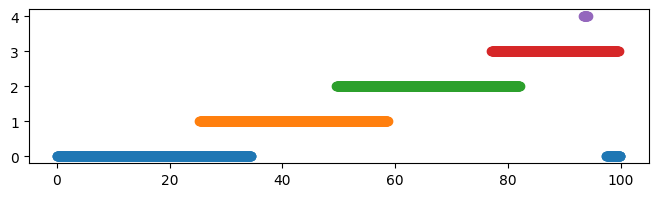

In [290]:
dat_path = r"Z:\projects\sequence_squad\organised_data\animals\\"
awake_ppseq_path = r"Z:\projects\sequence_squad\organised_data\ppseq_data\finalised_output\striatum\awake\\"
sleep_ppseq_path = r"Z:\projects\sequence_squad\organised_data\ppseq_data\finalised_output\striatum\paper_submission\post_sleep\\"

useable_mirs = ['EJT178_1_7','EJT149_1_1']

for mir in useable_mirs:
    # find organised path for each mir
    full_org_dat_path = find_organised_path(mir,dat_path)
    # load behavioural data
    behav_sync_csv = load_behav_sync(full_org_dat_path)
    
    # load in awake ppseq data for the same mir and pull in linearised thingy
    awake_ppseq_base_path = find_awake_ppseq_base_path(mir,awake_ppseq_path)
    
    
    ## extract simple metrics (number of trials, error rate, number of transitions,reward rate (vs time and vs transitions), number of each transition type)
    
    # load sequence order
    sequence_order = pd.read_csv(awake_ppseq_path + r'sequence_order.csv')
    # get continuous regions information
    continuous_regions_df = get_sequence_regions(mir,awake_ppseq_base_path,sequence_order)
    
    # tracking data 
    


    break

In [302]:

    os.listdir(os.path.join(full_org_dat_path,'video/tracking/'))

yes


['1_presleep', '2_task', '3_postsleep']

In [ ]:
if 'EJT' in mir:
    track_path = os.path.join(full_org_dat_path,'video/tracking/')
    for item in os.listdir(track_path):
        if 'task' in item:
            full_track_path = os.path.join(track_path,item)
    for tracking_file in os.listdir(full_track_path):
        if 'back' in tracking_file and 'task' in tracking_file and '.h5' in tracking_file:
            task_tracking_csv = os.path.join(full_track_path,tracking_file)
            break
    for tracking_file in os.listdir(full_track_path):
        if 'back' in tracking_file and 'port' in tracking_file and '.h5' in tracking_file:
            port_tracking_csv = os.path.join(full_track_path,tracking_file)
            break
        
    # load in tracking data:        
    back_head_centre = get_dlc_data(task_tracking_csv,interp = True,val = 0.9995)
    back_ports = get_dlc_data(port_tracking_csv,interp = True,val = 0.9995)

    if 'head_centre' in list(back_head_centre):
        back_head_centre_df = back_head_centre['head_centre'][0] 

head_centre
function exiting
function exiting
implant_centre
function exiting
function exiting
left_ear
function exiting
function exiting
right_ear
function exiting
function exiting
tail_base
function exiting
function exiting
port1
function exiting
function exiting
port2
function exiting
function exiting
port3
function exiting
function exiting
port6
function exiting
function exiting
port7
function exiting
function exiting


In [343]:
back_head_centre_df

coords,x,y,likelihood,interped_x,interped_y
0,366.061066,584.250671,0.999597,366.061066,584.250671
1,365.491608,585.148315,0.999591,365.491608,585.148315
2,364.315460,585.561768,0.999709,364.315460,585.561768
3,363.241913,585.304504,0.999731,363.241913,585.304504
4,362.535126,584.520691,0.999748,362.535126,584.520691
...,...,...,...,...,...
164722,0.000000,0.000000,0.000177,0.000000,0.000000
164723,0.000000,0.000000,0.000294,0.000000,0.000000
164724,0.000000,0.000000,0.000203,0.000000,0.000000
164725,0.000000,0.000000,0.000064,0.000000,0.000000


In [337]:
back_head_centre

{'head_centre': [coords           x           y  likelihood  interped_x  interped_y
  0       366.061066  584.250671    0.999597  366.061066  584.250671
  1       365.491608  585.148315    0.999591  365.491608  585.148315
  2       364.315460  585.561768    0.999709  364.315460  585.561768
  3       363.241913  585.304504    0.999731  363.241913  585.304504
  4       362.535126  584.520691    0.999748  362.535126  584.520691
  ...            ...         ...         ...         ...         ...
  164722    0.000000    0.000000    0.000177    0.000000    0.000000
  164723    0.000000    0.000000    0.000294    0.000000    0.000000
  164724    0.000000    0.000000    0.000203    0.000000    0.000000
  164725    0.000000    0.000000    0.000064    0.000000    0.000000
  164726    0.000000    0.000000    0.000110    0.000000    0.000000
  
  [164727 rows x 5 columns]],
 'implant_centre': [coords           x           y  likelihood  interped_x  interped_y
  0       359.682373  539.862183    0

['head_centre', 'implant_centre', 'left_ear', 'right_ear', 'tail_base']

In [332]:
back_head_centre

{'head_centre': [coords           x           y  likelihood  interped_x  interped_y
  0       366.061066  584.250671    0.999597  366.061066  584.250671
  1       365.491608  585.148315    0.999591  365.491608  585.148315
  2       364.315460  585.561768    0.999709  364.315460  585.561768
  3       363.241913  585.304504    0.999731  363.241913  585.304504
  4       362.535126  584.520691    0.999748  362.535126  584.520691
  ...            ...         ...         ...         ...         ...
  164722    0.000000    0.000000    0.000177    0.000000    0.000000
  164723    0.000000    0.000000    0.000294    0.000000    0.000000
  164724    0.000000    0.000000    0.000203    0.000000    0.000000
  164725    0.000000    0.000000    0.000064    0.000000    0.000000
  164726    0.000000    0.000000    0.000110    0.000000    0.000000
  
  [164727 rows x 5 columns]],
 'implant_centre': [coords           x           y  likelihood  interped_x  interped_y
  0       359.682373  539.862183    0

In [331]:
list(back_ports)

['port1', 'port2', 'port3', 'port6', 'port7']

In [328]:
back_p1

'port1'

In [326]:
back_head_centre

{'head_centre': [coords           x           y  likelihood  interped_x  interped_y
  0       366.061066  584.250671    0.999597  366.061066  584.250671
  1       365.491608  585.148315    0.999591  365.491608  585.148315
  2       364.315460  585.561768    0.999709  364.315460  585.561768
  3       363.241913  585.304504    0.999731  363.241913  585.304504
  4       362.535126  584.520691    0.999748  362.535126  584.520691
  ...            ...         ...         ...         ...         ...
  164722    0.000000    0.000000    0.000177    0.000000    0.000000
  164723    0.000000    0.000000    0.000294    0.000000    0.000000
  164724    0.000000    0.000000    0.000203    0.000000    0.000000
  164725    0.000000    0.000000    0.000064    0.000000    0.000000
  164726    0.000000    0.000000    0.000110    0.000000    0.000000
  
  [164727 rows x 5 columns]],
 'implant_centre': [coords           x           y  likelihood  interped_x  interped_y
  0       359.682373  539.862183    0

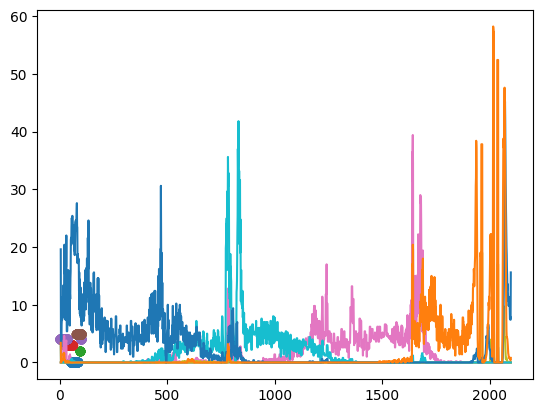

In [244]:
standard_space_path = awake_ppseq_base_path + r'//analysis_output/reordered_recolored/fixed_standard_space//'
overlap_positions_standard_space = np.load(standard_space_path + 'overlap_positions_standard_space.npy',allow_pickle=True)
for i,seq in enumerate(overlap_positions_standard_space):
    plt.plot(seq,np.ones(len(seq))*i,'o')
    
df = pd.read_csv(standard_space_path + 'binned_seq_occurance_df.csv')
for column in df.columns[1::]:
    df[column] = df[column].rolling(window=5).mean()
    plt.plot(df[column])

In [179]:
os.listdir(standard_space_path)

['binned_seq_occurance_df.csv',
 'chunks.png',
 'overlap_positions.npy',
 'overlap_positions_standard_space.npy',
 'smoothed_counts.npy',
 'standard_space_dominant_thrsholded_smallremoved.png',
 'standard_space_warped.png',
 'tracking_port_radius.png',
 'video_scoring_extra_seqs.mp4',
 'warped_x.npy']

In [136]:
behav_sync_csv

,Unnamed: 0,Trial_id,Trial_Start,Port,PokeIn_Time,PokeOut_Time,Reward_Times,Trial_End,Port_2-3-4-5_LED_intensities,Port_1-2-3-4_RewardAmount,...,backcam_aligned_pokeout_times,backcam_trialstart_timestamps,sidecam_trialstart_seconds,sidecam_aligned_pokein_times,sidecam_aligned_pokeout_times,sidecam_trialstart_timestamps,bottomcam_trialstart_seconds,bottomcam_aligned_pokein_times,bottomcam_aligned_pokeout_times,bottomcam_trialstart_timestamps
0,0,1,83.3787,3,83.7602,83.9469,NaN,105.165,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",...,97.051533,5789.0,96.483333,96.864833,97.051533,5789.0,96.416667,96.798167,96.984867,5785.0
1,1,1,83.3787,7,84.6853,84.6954,NaN,105.165,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",...,97.800033,5789.0,96.483333,97.789933,97.800033,5789.0,96.416667,97.723267,97.733367,5785.0
2,2,1,83.3787,7,84.7098,84.8058,NaN,105.165,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",...,97.910433,5789.0,96.483333,97.814433,97.910433,5789.0,96.416667,97.747767,97.843767,5785.0
3,3,1,83.3787,3,90.5328,90.5555,NaN,105.165,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",...,103.660133,5789.0,96.483333,103.637433,103.660133,5789.0,96.416667,103.570767,103.593467,5785.0
4,4,1,83.3787,1,91.9452,92.1325,NaN,105.165,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",...,105.237133,5789.0,96.483333,105.049833,105.237133,5789.0,96.416667,104.983167,105.170467,5785.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3356,3356,403,2336.9127,2,2338.5655,2338.6056,NaN,2340.365,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",...,2352.892900,141072.0,2351.283333,2352.936133,2352.976233,141077.0,2351.133333,2352.786133,2352.826233,141068.0
3357,3357,403,2336.9127,1,2338.9027,2338.9792,NaN,2340.365,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",...,2353.266500,141072.0,2351.283333,2353.273333,2353.349833,141077.0,2351.133333,2353.123333,2353.199833,141068.0
3358,3358,403,2336.9127,6,2339.1753,2339.2380,NaN,2340.365,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",...,2353.525300,141072.0,2351.283333,2353.545933,2353.608633,141077.0,2351.133333,2353.395933,2353.458633,141068.0
3359,3359,403,2336.9127,3,2339.5967,2339.6011,NaN,2340.365,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",...,2353.888400,141072.0,2351.283333,2353.967333,2353.971733,141077.0,2351.133333,2353.817333,2353.821733,141068.0


In [133]:
behav_sync_csv_path

'Z:\\projects\\sequence_squad\\organised_data\\animals\\\\EJT149_implant1\\recording1_16-11-2021\\behav_sync/2_task\\Behav_Ephys_Camera_Sync.csv'

In [2]:
### is there a link between behaviour and the replay we see? 

## load all the replay sessions that i have...
## look for a correlation:
# number of trials
# amount of each motif
# how variable each motif is
# number of errors
# reward rate
# others?

# so i need to load the behavioural data to take standard measures
# then take the tracking data to extract variability
# most complicated will be working out how to map the motifs to the task.. 
# # should be okay because I know where on the linearised task thye sit so i just take these positions. 


# do these correlate with replay rate, a characteristic of replay? motif specific replay? 

In [ ]:
## is there a link between replay and behaviour?

# need session before and after - take basic meausures as before 
# I think take same meausures as before 
# does replay predict a change? 
